# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import gaussian_kde
import os
import matplotlib.cm as cm

sns.set_context("talk")

# Read in and clean mySAS data

In [2]:
os.chdir("../..")

Li_file = 'mysasData/06122025/LI_LOG.txt'

# Explicit header that matches your logger columns
colnames = ["Time", "Sensor", "415", "445", "480", "515", "555", "590", "630", "680", "930", "Clear", "ASTEP", "ATIME", "GAIN", "Voltage"]

# Read the file without a header row, then assign proper column names
my_LI = pd.read_csv(Li_file, header=None, names=colnames)

# Check it worked
print(f"Rows before filtering: {len(my_LI)}")
my_LI.head()


Rows before filtering: 984


Time Sensor   415    445    480    515    555    590    630  \
0  2025-06-11 14:17:10     Li  6862  10259  14205  16336  15779  17141  20284   
1  2025-06-11 14:17:12     Li  6680   9988  13792  15814  15161  16408  19327   
2  2025-06-11 14:17:14     Li  6490   9713  13374  15291  14617  15759  18505   
3  2025-06-11 14:17:17     Li  6318   9465  12994  14824  14129  15193  17772   
4  2025-06-11 14:17:19     Li  6157   9227  12633  14377  13641  14622  17048   

     680   930  Clear  ASTEP  ATIME  GAIN  Voltage  
0  18972  8771  36779   1000    255     5     0.96  
1  17990  8204  36114   1000    255     5     0.96  
2  17144  7759  35517   1000    255     5     0.97  
3  16402  7427  35067   1000    255     5     0.97  
4  15662  7164  34675   1000    255     5     0.97

In [3]:
# Set up output dir
output_dir = "comparisonOutputs/L1BQC/LI/"

## Convert Time

In [4]:
# Parse Time column, coerce bad entries to NaT
my_LI['Time'] = pd.to_datetime(my_LI['Time'], errors='coerce')

# Drop rows where Time is NaN
my_LI = my_LI.dropna(subset=['Time'])

# Correct actual deployment time (was mistakenly set to June 11)
actual_start = pd.Timestamp('2025-06-12 15:59:26') 
simulated_start = my_LI['Time'].iloc[0]

# Compute and apply offset
time_offset = actual_start - simulated_start
my_LI['Time_UTC'] = my_LI['Time'] + time_offset
my_LI.head()

Time Sensor   415    445    480    515    555    590    630  \
0 2025-06-11 14:17:10     Li  6862  10259  14205  16336  15779  17141  20284   
1 2025-06-11 14:17:12     Li  6680   9988  13792  15814  15161  16408  19327   
2 2025-06-11 14:17:14     Li  6490   9713  13374  15291  14617  15759  18505   
3 2025-06-11 14:17:17     Li  6318   9465  12994  14824  14129  15193  17772   
4 2025-06-11 14:17:19     Li  6157   9227  12633  14377  13641  14622  17048   

     680   930  Clear  ASTEP  ATIME  GAIN  Voltage            Time_UTC  
0  18972  8771  36779   1000    255     5     0.96 2025-06-12 15:59:26  
1  17990  8204  36114   1000    255     5     0.96 2025-06-12 15:59:28  
2  17144  7759  35517   1000    255     5     0.97 2025-06-12 15:59:30  
3  16402  7427  35067   1000    255     5     0.97 2025-06-12 15:59:33  
4  15662  7164  34675   1000    255     5     0.97 2025-06-12 15:59:35

## Convert counts for gain and integration

In [5]:
# Compute T_int in microseconds
my_LI['Tint_us'] = (my_LI['ATIME'] + 1) * my_LI['ASTEP'] * 2.78  # µs

# Map GAIN enum to multiplier
gain_enum_to_mult = {
    0: 0.5, 1: 1, 2: 2, 3: 4,
    4: 8, 5: 16, 6: 32, 7: 64,
    8: 128, 9: 256
}
my_LI['GAIN_MULT'] = my_LI['GAIN'].map(gain_enum_to_mult)

# Compute correction factor
my_LI['CORRECTION'] = my_LI['GAIN_MULT'] * my_LI['Tint_us']


In [6]:
# Define spectral channels
spectral_channels = ['415', '445', '480', '515', '555', '590', '630', '680']

# Apply correction to each spectral channel
corrected_data = my_LI[spectral_channels].div(my_LI['CORRECTION'], axis=0)

# Create new DataFrame with Time_UTC and corrected values
my_LI_corrected = pd.concat([my_LI['Time_UTC'], corrected_data], axis=1)

# Rename columns to indicate correction
my_LI_corrected.columns = ['Time_UTC'] + [f"{ch}_corr" for ch in spectral_channels]

## Remove first 2 min and last 2 min of data

In [7]:
# # Define time range
# start_time = my_LI_corrected['Time_UTC'].min()
# end_time = my_LI_corrected['Time_UTC'].max()

# cutoff_start = start_time + pd.Timedelta(minutes=10)
# cutoff_end = end_time - pd.Timedelta(minutes=2)

# # Trim to middle section
# my_LI_trimmed = my_LI_corrected[
#     (my_LI_corrected['Time_UTC'] > cutoff_start) &
#     (my_LI_corrected['Time_UTC'] < cutoff_end)
# ].copy()
# print(f"Remaining rows after filtering: {len(my_LI_trimmed)}")

In [8]:
cutoff_start = pd.Timestamp('2025-06-12 16:24:00')
cutoff_end   = pd.Timestamp('2025-06-12 16:35:00')

my_LI_trimmed = my_LI_corrected[
    (my_LI_corrected['Time_UTC'] >= cutoff_start) &
    (my_LI_corrected['Time_UTC'] <= cutoff_end)
].copy()

print(f"Remaining rows after filtering: {len(my_LI_trimmed)}")


Remaining rows after filtering: 264


## Remove any oversaturation

In [9]:
# Define spectral channels again
spectral_channels = ['415', '445', '480', '515', '555', '590', '630', '680']

# Find rows where any of the spectral bands hit saturation (65535)
saturated_mask = (my_LI[spectral_channels] >= 65535).any(axis=1)

# Apply the same time filter to get valid timestamps
valid_times = my_LI_trimmed['Time_UTC']

# Create a filtered version of the saturation mask for only the rows in my_LI_trimmed
saturated_times = my_LI.loc[saturated_mask, 'Time_UTC']

# Filter out saturated times
my_LI_cleaned = my_LI_trimmed[~my_LI_trimmed['Time_UTC'].isin(saturated_times)].copy()
my_LI_cleaned.head()

Time_UTC  415_corr  445_corr  480_corr  515_corr  555_corr  \
592 2025-06-12 16:24:02  0.000423  0.000634  0.000847  0.000942  0.000868   
593 2025-06-12 16:24:04  0.000423  0.000634  0.000846  0.000941  0.000867   
594 2025-06-12 16:24:07  0.000423  0.000634  0.000846  0.000941  0.000867   
595 2025-06-12 16:24:09  0.000423  0.000634  0.000846  0.000941  0.000867   
596 2025-06-12 16:24:12  0.000424  0.000635  0.000848  0.000943  0.000869   

     590_corr  630_corr  680_corr  
592  0.000907  0.001027  0.000906  
593  0.000906  0.001026  0.000906  
594  0.000906  0.001026  0.000905  
595  0.000906  0.001026  0.000906  
596  0.000908  0.001028  0.000908

In [10]:
print(f"Remaining rows after filtering: {len(my_LI_cleaned)}")

Remaining rows after filtering: 264


## Plot Logger Spectra

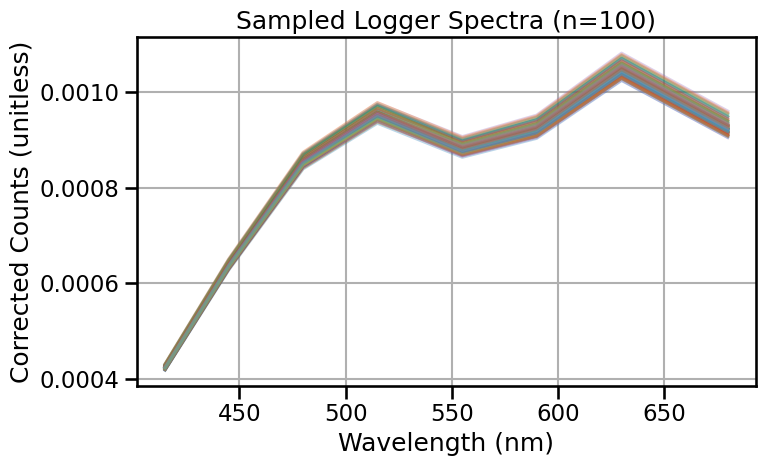

In [11]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
corr_cols = [f"{wl}_corr" for wl in wavelengths]

# Select 100 random samples
subset = my_LI_cleaned.sample(n=100, random_state=42).reset_index(drop=True)

# Plot all spectra using the same color
plt.figure(figsize=(8, 5))
for _, row in subset.iterrows():
    plt.plot(wavelengths, row[corr_cols], alpha=0.3)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Corrected Counts (unitless)")
plt.title("Sampled Logger Spectra (n=100)")
plt.grid(True)
plt.tight_layout()
plt.show()


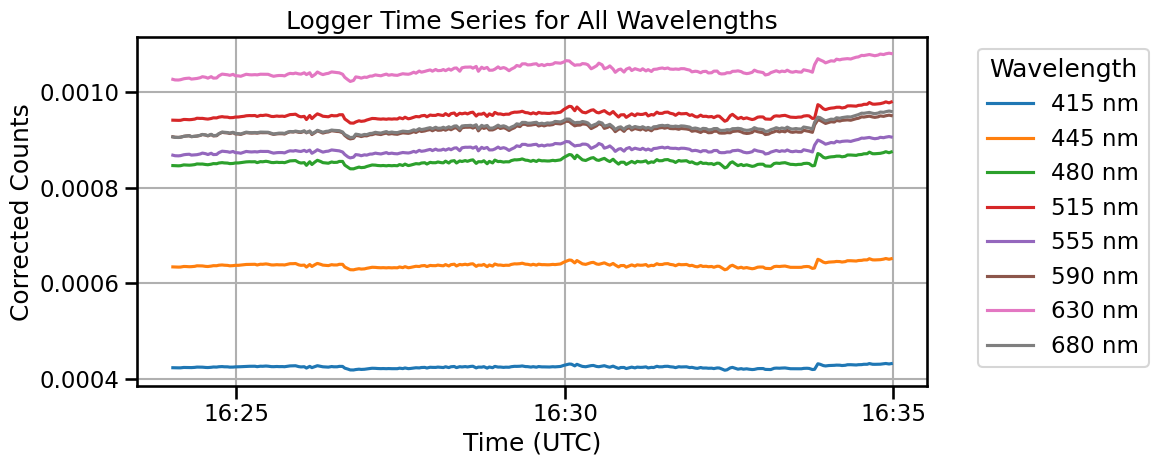

In [12]:
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

plt.figure(figsize=(12, 5))

for wl in wavelengths:
    col = f"{wl}_corr"
    plt.plot(my_LI_cleaned['Time_UTC'], my_LI_cleaned[col], label=f'{wl} nm')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (UTC)")
plt.ylabel("Corrected Counts")
plt.title("Logger Time Series for All Wavelengths")
plt.legend(title="Wavelength", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Read in pySAS data

In [13]:
Li_py_file = 'pysasData/Processed/L1BQC/pySAS_Li_L1BQC.csv' 
py_LI = pd.read_csv(Li_py_file)
py_LI.head()

Datetag     Timetag2     350.0     353.3     356.6     359.9     363.2  \
0  2025163.0  192945506.0  6.820947  6.897198  6.773200  6.850985  7.386040   
1  2025163.0  192946830.0  6.805299  6.925984  6.793176  6.853695  7.397543   
2  2025163.0  192949291.0  6.826139  6.904720  6.779356  6.857900  7.392882   
3  2025163.0  192951698.0  6.820730  6.922107  6.792114  6.837432  7.370136   
4  2025163.0  192952929.0  6.814700  6.923857  6.773424  6.844425  7.419044   

      366.5     369.8     373.1  ...     769.1     772.4     775.7     779.0  \
0  7.934919  7.915524  7.704121  ...  2.848861  3.044636  3.084934  3.082109   
1  7.953014  7.920237  7.716309  ...  2.853776  3.058601  3.095507  3.079447   
2  7.950864  7.950256  7.746010  ...  2.858984  3.036490  3.079651  3.089363   
3  7.956926  7.927707  7.711109  ...  2.844938  3.037483  3.101970  3.070573   
4  7.964907  7.911176  7.718122  ...  2.858539  3.041223  3.080396  3.098316   

      782.3     785.6     788.9     792.2     795.5     798.8  
0  2.969998  2.943695  2.852846  2.737323  2.765605  2.699146  
1  2.991147  2.936687  2.870729  2.841865  2.789646  2.747749  
2  3.019183  2.982942  2.876522  2.788068  2.768506  2.687381  
3  3.056974  2.991860  2.869104  2.808830  2.738540  2.691773  
4  2.991402  2.965886  2.897295  2.810010  2.722335  2.708545  

[5 rows x 139 columns]

In [14]:
print(f"Rows before filtering: {len(py_LI)}")

Rows before filtering: 2414


## Convert time

In [15]:
# Safely convert Datetag
datetag_clean = py_LI['Datetag'].astype(str).str.replace('.0', '', regex=False)
year = datetag_clean.str[:4].astype(int)
doy = datetag_clean.str[4:].astype(int)
date_part = pd.to_datetime(year * 1000 + doy, format='%Y%j')

# Parse Timetag2 as HHMMSSmmm
timetag_str = py_LI['Timetag2'].astype(int).astype(str).str.zfill(9)
hours = timetag_str.str[0:2].astype(int)
minutes = timetag_str.str[2:4].astype(int)
seconds = timetag_str.str[4:6].astype(int)
milliseconds = timetag_str.str[6:9].astype(int)

# Combine date and time
py_LI['Time_UTC'] = date_part + \
    pd.to_timedelta(hours, unit='h') + \
    pd.to_timedelta(minutes, unit='m') + \
    pd.to_timedelta(seconds, unit='s') + \
    pd.to_timedelta(milliseconds, unit='ms')

# Apply timezone shift from EDT to UTC
py_LI['Time_UTC'] -= pd.Timedelta(hours=4)
py_LI.head()

Datetag     Timetag2     350.0     353.3     356.6     359.9     363.2  \
0  2025163.0  192945506.0  6.820947  6.897198  6.773200  6.850985  7.386040   
1  2025163.0  192946830.0  6.805299  6.925984  6.793176  6.853695  7.397543   
2  2025163.0  192949291.0  6.826139  6.904720  6.779356  6.857900  7.392882   
3  2025163.0  192951698.0  6.820730  6.922107  6.792114  6.837432  7.370136   
4  2025163.0  192952929.0  6.814700  6.923857  6.773424  6.844425  7.419044   

      366.5     369.8     373.1  ...     772.4     775.7     779.0     782.3  \
0  7.934919  7.915524  7.704121  ...  3.044636  3.084934  3.082109  2.969998   
1  7.953014  7.920237  7.716309  ...  3.058601  3.095507  3.079447  2.991147   
2  7.950864  7.950256  7.746010  ...  3.036490  3.079651  3.089363  3.019183   
3  7.956926  7.927707  7.711109  ...  3.037483  3.101970  3.070573  3.056974   
4  7.964907  7.911176  7.718122  ...  3.041223  3.080396  3.098316  2.991402   

      785.6     788.9     792.2     795.5     798.8                Time_UTC  
0  2.943695  2.852846  2.737323  2.765605  2.699146 2025-06-12 15:29:45.506  
1  2.936687  2.870729  2.841865  2.789646  2.747749 2025-06-12 15:29:46.830  
2  2.982942  2.876522  2.788068  2.768506  2.687381 2025-06-12 15:29:49.291  
3  2.991860  2.869104  2.808830  2.738540  2.691773 2025-06-12 15:29:51.698  
4  2.965886  2.897295  2.810010  2.722335  2.708545 2025-06-12 15:29:52.929  

[5 rows x 140 columns]

In [16]:
# Map logger wavelengths to nearest pySAS band available
logger_to_pysas = {
    '415': '416.0',
    '445': '445.7',
    '480': '478.7',
    '515': '515.0',
    '555': '554.6',
    '590': '590.9',
    '630': '630.5',
    '680': '680.0'
}

# Create list of columns to extract
pysas_columns = ['Time_UTC'] + list(logger_to_pysas.values())

# Subset pySAS
py_LI_visible = py_LI[pysas_columns].copy()

# Rename columns to match logger names for easy comparison
rename_columns = {'Time_UTC': 'Time_UTC'}
rename_columns.update({v: f"{k}_pySAS" for k, v in logger_to_pysas.items()})
py_LI_visible.rename(columns=rename_columns, inplace=True)

# Preview
py_LI_visible.head()


Time_UTC  415_pySAS  445_pySAS  480_pySAS  515_pySAS  \
0 2025-06-12 15:29:45.506  10.935064  11.284847  10.899532   8.837977   
1 2025-06-12 15:29:46.830  10.959845  11.326819  10.944870   8.855397   
2 2025-06-12 15:29:49.291  10.965008  11.341081  10.955948   8.883153   
3 2025-06-12 15:29:51.698  10.935476  11.340182  10.941118   8.860713   
4 2025-06-12 15:29:52.929  10.953120  11.327486  10.956764   8.857891   

   555_pySAS  590_pySAS  630_pySAS  680_pySAS  
0   7.925095   6.546965   5.653053   4.602372  
1   7.927256   6.561763   5.652371   4.597167  
2   7.932803   6.586023   5.668216   4.574848  
3   7.915387   6.571123   5.665551   4.568861  
4   7.928128   6.557950   5.682437   4.572215

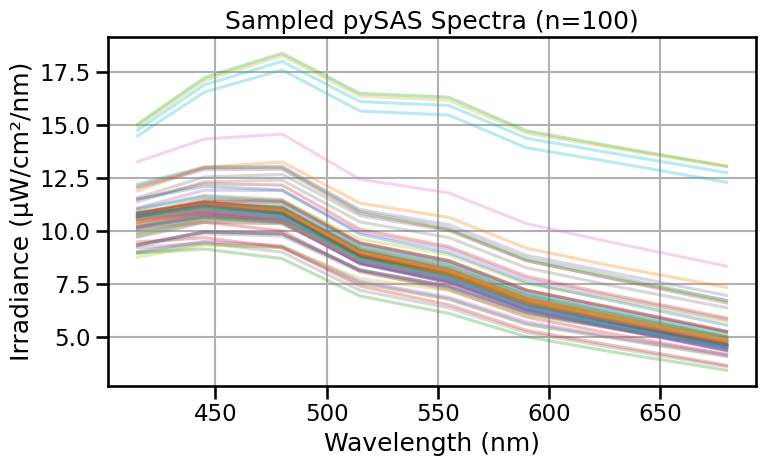

In [17]:
# Define pySAS spectral columns and corresponding wavelengths
pysas_cols = [f"{wl}_pySAS" for wl in [415, 445, 480, 515, 555, 590, 630, 680]]
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# Sample 100 rows
subset_py = py_LI_visible.sample(n=100, random_state=42)

# Plot spectra
plt.figure(figsize=(8, 5))
for _, row in subset_py.iterrows():
    plt.plot(wavelengths, row[pysas_cols], alpha=0.3)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance (µW/cm²/nm)")
plt.title("Sampled pySAS Spectra (n=100)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Match mySAS to pySAS

## Match time

In [18]:
# Round or floor pySAS timestamps to nearest second
py_LI['Time_UTC_trimmed'] = py_LI['Time_UTC'].dt.floor('s')

# Now subset using the trimmed column
start_time = my_LI_cleaned['Time_UTC'].min()
end_time = my_LI_cleaned['Time_UTC'].max()

py_LI_trimmed = py_LI[(py_LI['Time_UTC_trimmed'] >= start_time) & (py_LI['Time_UTC_trimmed'] <= end_time)].copy()

print(f"pySAS rows after time subsetting: {len(py_LI_trimmed)}")


pySAS rows after time subsetting: 241


## Match wavelengths

In [19]:
# Map logger wavelengths to nearest pySAS band available
logger_to_pysas = {
    '415': '416.0',
    '445': '445.7',
    '480': '478.7',
    '515': '515.0',
    '555': '554.6',
    '590': '590.9',
    '630': '630.5',
    '680': '680.0'
}

# Create list of columns to extract
pysas_columns = ['Time_UTC'] + list(logger_to_pysas.values())

# Subset pySAS
py_LI_visible = py_LI_trimmed[pysas_columns].copy()

# Rename columns to match logger names for easy comparison
rename_columns = {'Time_UTC': 'Time_UTC'}
rename_columns.update({v: f"{k}_pySAS" for k, v in logger_to_pysas.items()})
py_LI_visible.rename(columns=rename_columns, inplace=True)

# Preview
py_LI_visible.head()


Time_UTC  415_pySAS  445_pySAS  480_pySAS  515_pySAS  \
1546 2025-06-12 16:24:02.224  10.363301  10.871533  10.659468   8.716118   
1547 2025-06-12 16:24:04.340  10.336661  10.866377  10.634182   8.701406   
1548 2025-06-12 16:24:06.606  10.342763  10.860372  10.621437   8.663980   
1549 2025-06-12 16:24:08.796  10.334826  10.840008  10.607627   8.675346   
1550 2025-06-12 16:24:11.124  10.321478  10.848496  10.603299   8.669944   

      555_pySAS  590_pySAS  630_pySAS  680_pySAS  
1546   7.863618   6.525593   5.698878   4.696832  
1547   7.852899   6.524207   5.691571   4.677961  
1548   7.822039   6.519141   5.650979   4.667889  
1549   7.810940   6.518776   5.654445   4.662489  
1550   7.801379   6.504007   5.641844   4.670862

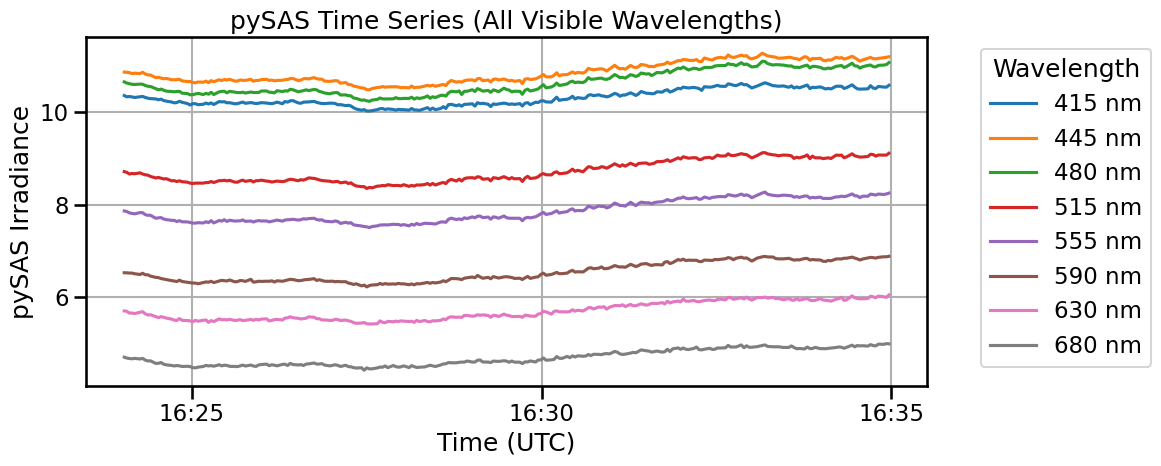

In [20]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

plt.figure(figsize=(12, 5))
for wl in wavelengths:
    plt.plot(py_LI_visible['Time_UTC'], py_LI_visible[f'{wl}_pySAS'], label=f'{wl} nm')

# Format x-axis to show only HH:MM
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (UTC)")
plt.ylabel("pySAS Irradiance")
plt.title("pySAS Time Series (All Visible Wavelengths)")
plt.legend(title="Wavelength", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Create Conversion factor

In [21]:
# Round both datasets' times to the nearest second
my_LI_cleaned['Time_UTC_rounded'] = my_LI_cleaned['Time_UTC'].dt.round('1s')
py_LI_visible['Time_UTC_rounded'] = py_LI_visible['Time_UTC'].dt.round('1s')

# Merge on the rounded timestamps
merged = pd.merge(
    my_LI_cleaned, py_LI_visible,
    on='Time_UTC_rounded', how='inner',
    suffixes=('_logger', '_pySAS')
)

# Check the merge result
merged.head()

Time_UTC_logger  415_corr  445_corr  480_corr  515_corr  555_corr  \
0 2025-06-12 16:24:02  0.000423  0.000634  0.000847  0.000942  0.000868   
1 2025-06-12 16:24:04  0.000423  0.000634  0.000846  0.000941  0.000867   
2 2025-06-12 16:24:07  0.000423  0.000634  0.000846  0.000941  0.000867   
3 2025-06-12 16:24:09  0.000423  0.000634  0.000846  0.000941  0.000867   
4 2025-06-12 16:24:22  0.000424  0.000635  0.000849  0.000944  0.000869   

   590_corr  630_corr  680_corr    Time_UTC_rounded          Time_UTC_pySAS  \
0  0.000907  0.001027  0.000906 2025-06-12 16:24:02 2025-06-12 16:24:02.224   
1  0.000906  0.001026  0.000906 2025-06-12 16:24:04 2025-06-12 16:24:04.340   
2  0.000906  0.001026  0.000905 2025-06-12 16:24:07 2025-06-12 16:24:06.606   
3  0.000906  0.001026  0.000906 2025-06-12 16:24:09 2025-06-12 16:24:08.796   
4  0.000908  0.001028  0.000908 2025-06-12 16:24:22 2025-06-12 16:24:22.363   

   415_pySAS  445_pySAS  480_pySAS  515_pySAS  555_pySAS  590_pySAS  \
0  10.363301  10.871533  10.659468   8.716118   7.863618   6.525593   
1  10.336661  10.866377  10.634182   8.701406   7.852899   6.524207   
2  10.342763  10.860372  10.621437   8.663980   7.822039   6.519141   
3  10.334826  10.840008  10.607627   8.675346   7.810940   6.518776   
4  10.306960  10.810181  10.565073   8.640322   7.769898   6.481865   

   630_pySAS  680_pySAS  
0   5.698878   4.696832  
1   5.691571   4.677961  
2   5.650979   4.667889  
3   5.654445   4.662489  
4   5.611686   4.615937

In [22]:
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
regression_results = []

for wl in wavelengths:
    logger_col = f'{wl}_corr'
    pysas_col = f'{wl}_pySAS'

    # Drop NaNs
    valid = merged[[logger_col, pysas_col]].dropna()

    x = valid[logger_col].values.reshape(-1, 1)
    y = valid[pysas_col].values

    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(x, y)

    # Calculate RMSE
    y_pred = model.predict(x)
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))

    regression_results.append({
        'Wavelength': wl,
        'Slope': slope,
        'Intercept': intercept,
        'R²': r2,
        'RMSE': rmse
    })

    # Store predictions for plotting
    valid['pred'] = y_pred
    regression_results[-1]['data'] = valid


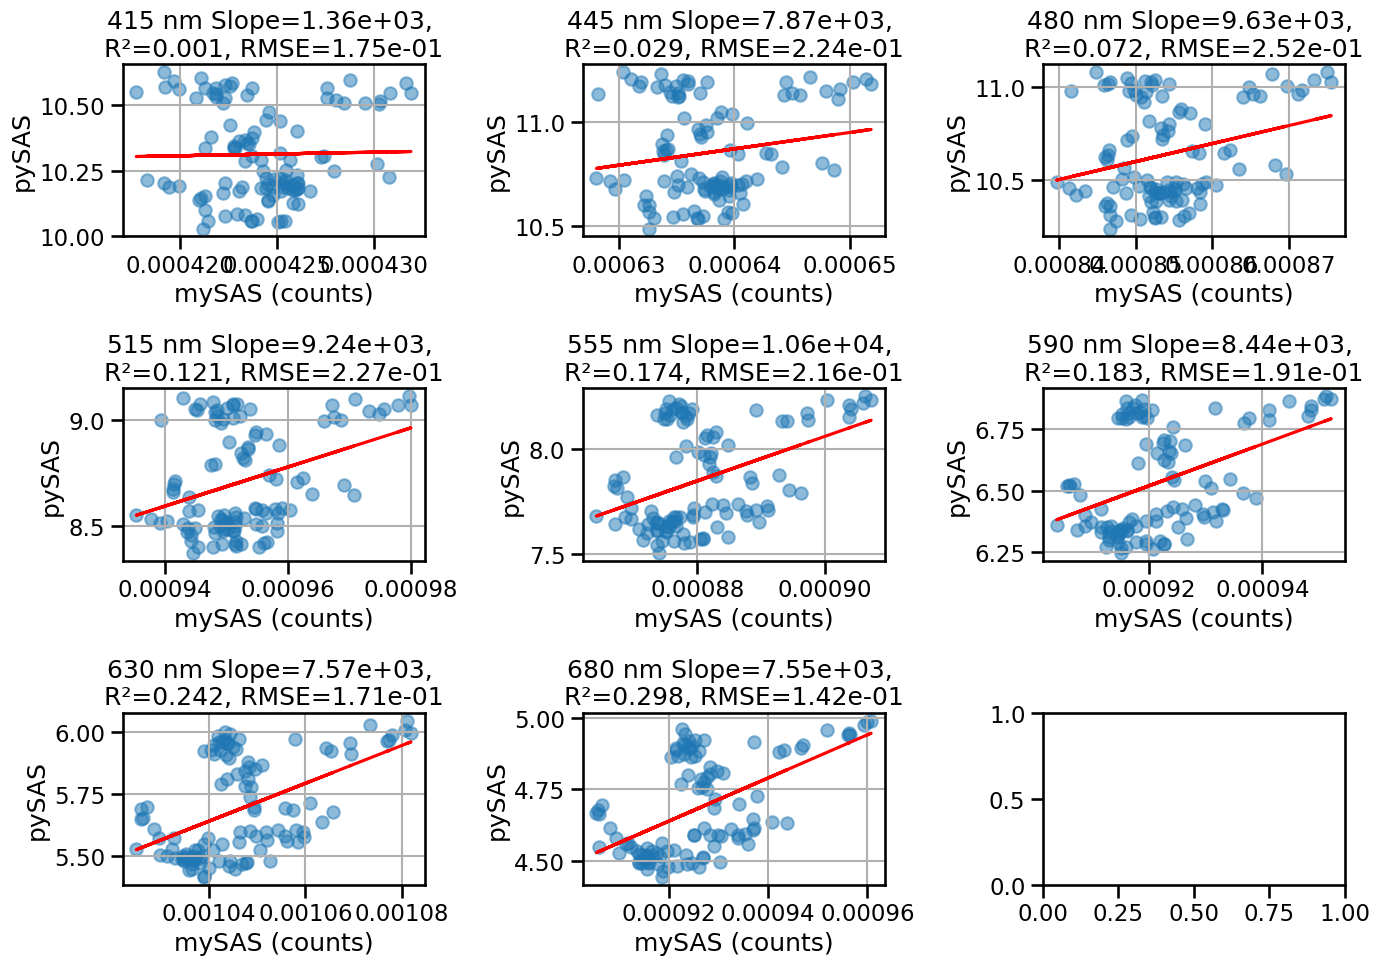

In [23]:
# Plot
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, res in enumerate(regression_results):
    ax = axes[i]
    data = res['data']
    wl = res['Wavelength']

    ax.scatter(data[f'{wl}_corr'], data[f'{wl}_pySAS'], alpha=0.5, label='Data')
    ax.plot(data[f'{wl}_corr'], data['pred'], color='red', label='Fit')

    # Updated title to include RMSE
    ax.set_title(
        f"{wl} nm Slope={res['Slope']:.3g}, \nR²={res['R²']:.3f}, RMSE={res['RMSE']:.2e}"
    )

    ax.set_xlabel('mySAS (counts)')
    ax.set_ylabel('pySAS')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [24]:
# Create summary DataFrame from regression results
summary_df = pd.DataFrame(regression_results).drop(columns='data')

# Display
print(summary_df.to_string(index=False))

# Export regression summary to CSV
summary_df.to_csv(os.path.join(output_dir, "mySAS_pySAS_Li_regression_summary.csv"), index=False)

 Wavelength        Slope  Intercept       R²     RMSE
        415  1359.810932   9.735695 0.000509 0.174578
        445  7867.680953   5.835432 0.028595 0.223958
        480  9630.487296   2.411726 0.072466 0.252443
        515  9238.004243  -0.088307 0.121279 0.227153
        555 10583.941951  -1.466421 0.173688 0.215936
        590  8440.535529  -1.245487 0.183223 0.190656
        630  7572.592100  -2.233786 0.241862 0.170880
        680  7546.791877  -2.303519 0.298284 0.141941


# Apply Conversion Factor

In [25]:
my_LI_converted = pd.DataFrame()
my_LI_converted['Time_UTC'] = my_LI_cleaned['Time_UTC']

for _, row in summary_df.iterrows():
    wl = int(row['Wavelength'])  # Convert to integer
    slope = row['Slope']
    intercept = row['Intercept']

    input_col = f"{wl}_corr"
    output_col = f"{wl}_converted"

    my_LI_converted[output_col] = my_LI_cleaned[input_col] * slope + intercept


In [26]:
my_LI_converted['Time_UTC_rounded'] = my_LI_converted['Time_UTC'].dt.round('1s')
py_LI_visible['Time_UTC_rounded'] = py_LI_visible['Time_UTC'].dt.round('1s')


In [27]:
merged_converted = pd.merge(
    my_LI_converted, py_LI_visible,
    on='Time_UTC_rounded', how='inner', suffixes=('_logger', '_pySAS')
)

merged_converted.to_csv(os.path.join(output_dir,"mySAS_pySAS_Li_converted.csv"), index=False)

# Figures

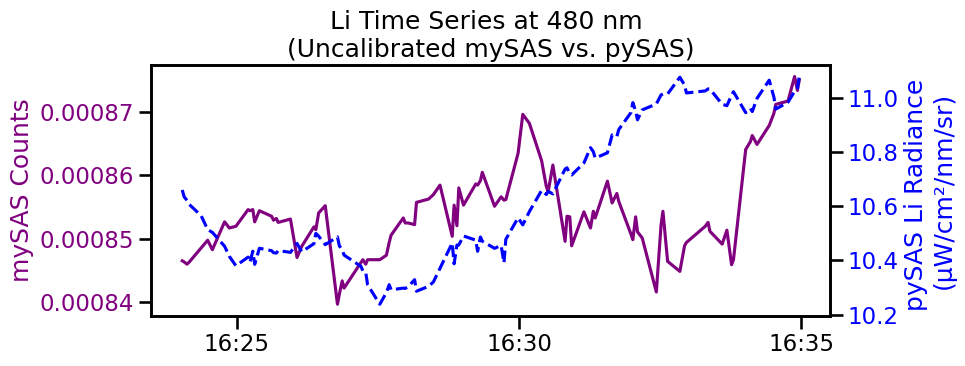

In [28]:
wl = 480  # Example wavelength

fig, ax1 = plt.subplots(figsize=(10, 4))

# Left axis: raw logger counts
ax1.plot(merged['Time_UTC_rounded'], merged[f'{wl}_corr'], color='purple', label='Logger (raw)')
ax1.set_ylabel('mySAS Counts', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
#ax1.set_xlabel('Time (UTC)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Right axis: pySAS irradiance
ax2 = ax1.twinx()
ax2.plot(merged['Time_UTC_rounded'], merged[f'{wl}_pySAS'], color='blue', linestyle='--', label='pySAS')
ax2.set_ylabel('pySAS Li Radiance \n(µW/cm²/nm/sr)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f"Li Time Series at {wl} nm \n(Uncalibrated mySAS vs. pySAS)")
fig.tight_layout()
plt.savefig(os.path.join(output_dir, "mySAS_vs_pySAS_Li_TS_unCorr.png"), dpi=300, bbox_inches='tight')
plt.show()


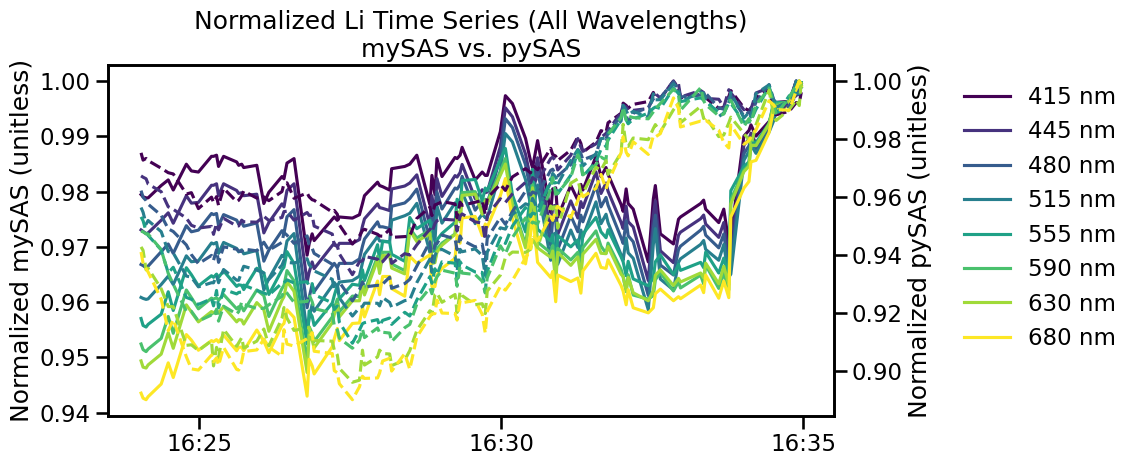

In [29]:
# Wavelengths to include
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# Generate a colormap for wavelength color coding
colors = cm.viridis(np.linspace(0, 1, len(wavelengths)))

# Create plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot normalized mySAS counts (left y-axis)
for wl, color in zip(wavelengths, colors):
    y_logger = merged[f'{wl}_corr'] / merged[f'{wl}_corr'].max()
    ax1.plot(merged['Time_UTC_rounded'], y_logger, color=color, label=f'{wl} nm (mySAS)')

ax1.set_ylabel('Normalized mySAS (unitless)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add second y-axis for pySAS (right y-axis)
ax2 = ax1.twinx()
for wl, color in zip(wavelengths, colors):
    y_pysas = merged[f'{wl}_pySAS'] / merged[f'{wl}_pySAS'].max()
    ax2.plot(merged['Time_UTC_rounded'], y_pysas, linestyle='--', color=color, label=f'{wl} nm (pySAS)')

ax2.set_ylabel('Normalized pySAS (unitless)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Create custom legend (one entry per wavelength)
handles = [plt.Line2D([0], [0], color=color, label=f"{wl} nm") for wl, color in zip(wavelengths, colors)]

# Legend in upper right, outside plot, no frame, 2 columns
ax1.legend(handles=handles,
           title='',
           loc='upper left',
           bbox_to_anchor=(1.15, 1),  # shift further right
           ncol=1,
           frameon=False)

plt.title("Normalized Li Time Series (All Wavelengths)\nmySAS vs. pySAS")
plt.xticks(rotation=45)

fig.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Li_TS_allWavelengths_normalized.png"), dpi=300, bbox_inches='tight')
plt.show()


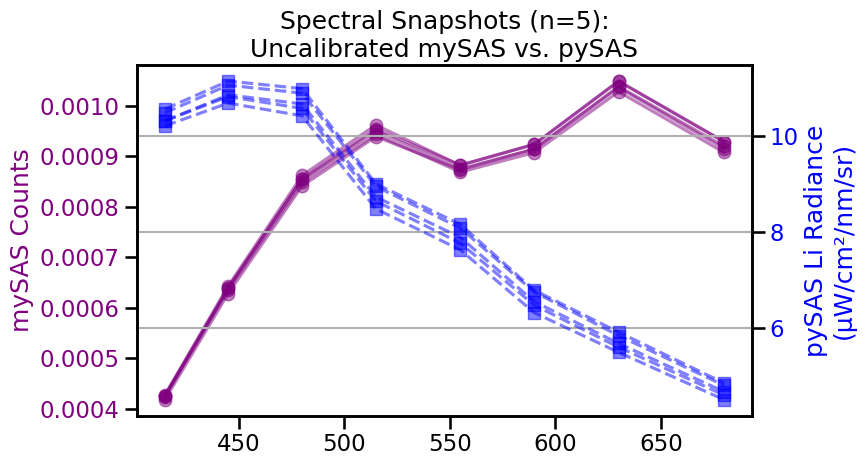

In [31]:
# Pick 5 random snapshots from merged
subset = merged.sample(n=5, random_state=42)

fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot raw mySAS counts (left y-axis)
for _, row in subset.iterrows():
    logger_vals = [row[f'{wl}_corr'] for wl in wavelengths]
    ax1.plot(wavelengths, logger_vals, color='purple', alpha=0.5, marker='o', linestyle='-')

ax1.set_ylabel("mySAS Counts", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Plot pySAS irradiance (right y-axis)
ax2 = ax1.twinx()
for _, row in subset.iterrows():
    pysas_vals = [row[f'{wl}_pySAS'] for wl in wavelengths]
    ax2.plot(wavelengths, pysas_vals, color='blue', alpha=0.5, marker='s', linestyle='--')

ax2.set_ylabel("pySAS Li Radiance\n(µW/cm²/nm/sr)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.xlabel("Wavelength (nm)")
plt.title("Spectral Snapshots (n=5):\nUncalibrated mySAS vs. pySAS")
plt.grid(True)
fig.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Li_spectra_unCorr_multi.png"), dpi=300, bbox_inches='tight')
plt.show()


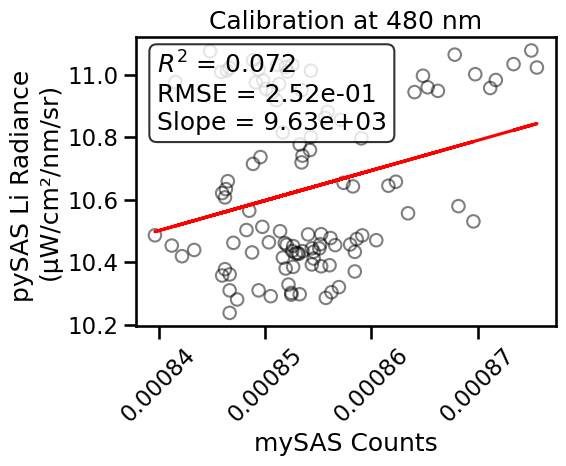

In [32]:
# Choose wavelength
wl = 480
x = merged[f'{wl}_corr'].values.reshape(-1, 1)
y = merged[f'{wl}_pySAS'].values

# Fit linear regression
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)

slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(x, y)
rmse = np.sqrt(np.mean((y - y_pred) ** 2))

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(x, y, alpha=0.5, label='Data', edgecolor='k', facecolor='none')
plt.plot(x, y_pred, color='red', label='Fit')

# Annotate stats
plt.title(f"Calibration at {wl} nm")
plt.xlabel("mySAS Counts")
plt.ylabel("pySAS Li Radiance \n(µW/cm²/nm/sr)")
plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.2e}\nSlope = {slope:.3g}",
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Li_regression.png"), dpi=300, bbox_inches='tight')
plt.show()


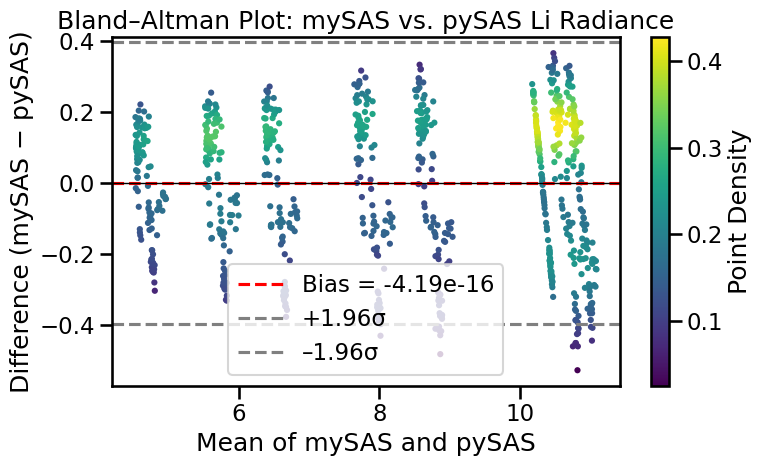

In [34]:
# Flatten all logger and pySAS values
logger_flat = merged_converted[[f'{wl}_converted' for wl in wavelengths]].to_numpy().flatten()
pysas_flat  = merged_converted[[f'{wl}_pySAS' for wl in wavelengths]].to_numpy().flatten()

# Mean and difference
mean_vals = (logger_flat + pysas_flat) / 2
diff_vals = logger_flat - pysas_flat

# Compute density
xy = np.vstack([mean_vals, diff_vals])
density = gaussian_kde(xy)(xy)

# Compute Bland–Altman stats
bias = np.mean(diff_vals)
loa = 1.96 * np.std(diff_vals)

# Plot
plt.figure(figsize=(8, 5))
sc = plt.scatter(mean_vals, diff_vals, c=density, cmap='viridis', s=20, edgecolor='none')
plt.axhline(bias, color='red', linestyle='--', label=f'Bias = {bias:.2e}')
plt.axhline(bias + loa, color='gray', linestyle='--', label='+1.96σ')
plt.axhline(bias - loa, color='gray', linestyle='--', label='–1.96σ')
plt.axhline(0, color='black', linewidth=1)

# Labels and style
plt.xlabel("Mean of mySAS and pySAS")
plt.ylabel("Difference (mySAS − pySAS)")
plt.title("Bland–Altman Plot: mySAS vs. pySAS Li Radiance")
plt.colorbar(sc, label='Point Density')
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig(os.path.join(output_dir,"Bland_Altman_Li_ptDensity.png"), dpi=300, bbox_inches='tight')
plt.show()


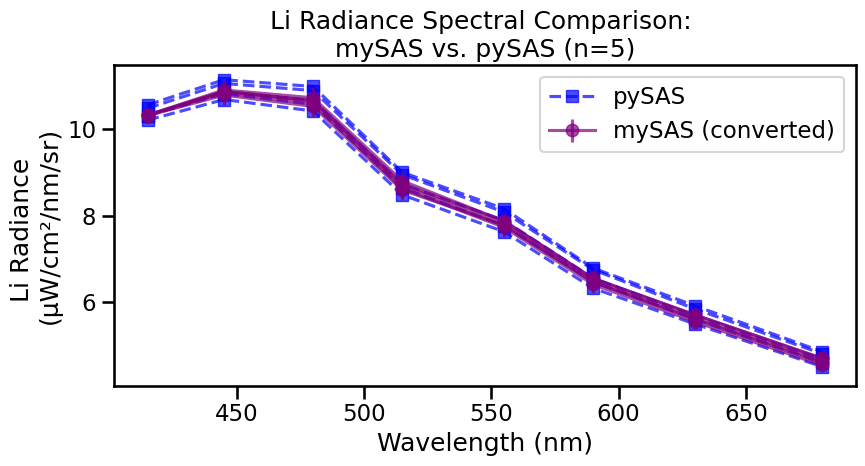

In [35]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
logger_cols = [f'{wl}_converted' for wl in wavelengths]
pysas_cols  = [f'{wl}_pySAS' for wl in wavelengths]

# Get RMSE per wavelength from regression_results
rmse_map = {res['Wavelength']: res['RMSE'] for res in regression_results}
yerr = [rmse_map[wl] for wl in wavelengths]

# Sample 5 timepoints from the merged data
subset = merged_converted.sample(n=5, random_state=42)

# Plot
plt.figure(figsize=(9, 5))

for _, row in subset.iterrows():
    logger_vals = row[logger_cols].values
    pysas_vals  = row[pysas_cols].values

    # Logger with error bars
    plt.errorbar(wavelengths, logger_vals, yerr=yerr,
                 fmt='o-', color='purple', alpha=0.7, label='mySAS (converted)')

    # pySAS as dashed line
    plt.plot(wavelengths, pysas_vals, linestyle='--', marker='s',
             color='blue', alpha=0.7, label='pySAS')

# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.xlabel("Wavelength (nm)")
plt.ylabel("Li Radiance \n(µW/cm²/nm/sr)")
plt.title("Li Radiance Spectral Comparison: \nmySAS vs. pySAS (n=5)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Li_spectra.png"), dpi=300, bbox_inches='tight')
plt.show()
